<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/week10/HumanActivityLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/ML_Class/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/ML_Class/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape


/tmp/ipython-input-924603705.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-924603705.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-924603705.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-924603705.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 입력, 출력 크기 확인
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

# ===== 단일 LSTM 모델 =====
simple_lstm = Sequential([
    LSTM(128, input_shape=(n_timesteps, n_features)),   # 단일 LSTM 층
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs, activation='softmax')
])

# ===== 컴파일 =====
simple_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
simple_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,942 (343.52 KB)

 Trainable params: 87,942 (343.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ===== 학습 =====
history = simple_lstm.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3910 - loss: 1.4328 - val_accuracy: 0.4827 - val_loss: 1.2237
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5065 - loss: 1.1795 - val_accuracy: 0.6723 - val_loss: 0.7798
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5919 - loss: 0.9023 - val_accuracy: 0.5928 - val_loss: 0.8294
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6300 - loss: 0.7965 - val_accuracy: 0.6642 - val_loss: 0.6817
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6789 - loss: 0.6962 - val_accuracy: 0.7893 - val_loss: 0.5542
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7386 - loss: 0.6053 - val_accuracy: 0.8328 - val_loss: 0.4471
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7963 - loss: 0.5265 - val_accuracy: 0.8470 - val_loss: 0.5003
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8158 - loss: 0.5369 - val_accu

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.9199185612487275
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       496
           1       0.95      0.97      0.96       471
           2       0.92      1.00      0.96       420
           3       0.88      0.73      0.80       491
           4       0.79      0.91      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



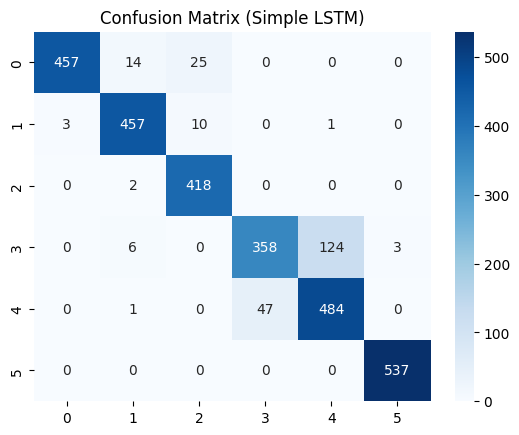

In [ ]:
# ===== 평가 =====
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pred = simple_lstm.predict(testX)
pred = np.argmax(pred, axis=-1)

cm = confusion_matrix(testy, pred)
print("Accuracy:", accuracy_score(testy, pred))
print(classification_report(testy, pred))

sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix (Simple LSTM)")
plt.show()